# Code for the paper: 
## Deep Learning for Fast Identification of Bacterial Strains in Low-Resource Devices

#### Loading libraries

In [1]:
# Imports here
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from PIL import Image

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [2]:
print(torch.__version__)

import sys
print(sys.version)

1.5.1
3.8.5 (default, Jul 28 2020, 12:59:40) 
[GCC 9.3.0]


## Data paths and hyperparameters

#### Hyperparameters and dataset details. 

You should use your own paths to the train, val and test folders.

In [3]:
## Data prepaYou should use your own paths to the train, val and test folders.ration and loading# Dataset details
dataset_version = 'augmented' # original or augmented
img_shape = (224,224)
img_size = str(img_shape[0])+"x"+str(img_shape[1])
train_dir = "Dataset/"+dataset_version+"_DIBaS_splits/"+img_size+"/train"
valid_dir = "Dataset/"+dataset_version+"_DIBaS_splits/"+img_size+"/val"
test_dir = "Dataset/"+dataset_version+"_DIBaS_splits/"+img_size+"/test"

# Hyperparameters
train_batch_size = 32
val_test_batch_size = 16
feature_extract = False
pretrained = True
h_epochs = 30

## Data preparation and loading

#### Defining transforms and creating dataloaders

In [4]:
#### Defining transforms and creating dataloaders# Define transforms for the training, validation, and testing sets
training_transforms = transforms.Compose([transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

testing_transforms = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
training_dataset = datasets.ImageFolder(train_dir, transform=training_transforms)
validation_dataset = datasets.ImageFolder(valid_dir, transform=validation_transforms)
testing_dataset = datasets.ImageFolder(test_dir, transform=testing_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=train_batch_size, shuffle=True)
print(len(train_loader))
validate_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=val_test_batch_size)
print(len(validate_loader))
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=val_test_batch_size)
print(len(test_loader))

581
249
249


#### Visualizing the target classes in dataset

In [7]:
train_labels = {value : key for (key, value) in training_dataset.class_to_idx.items()}
    
print(len(train_labels)) 
print(train_labels)

32
{0: 'Acinetobacter.baumanii', 1: 'Actinomyces.israeli', 2: 'Bacteroides.fragilis', 3: 'Bifidobacterium.spp', 4: 'Clostridium.perfringens', 5: 'Enterococcus.faecalis', 6: 'Enterococcus.faecium', 7: 'Escherichia.coli', 8: 'Fusobacterium', 9: 'Lactobacillus.casei', 10: 'Lactobacillus.crispatus', 11: 'Lactobacillus.delbrueckii', 12: 'Lactobacillus.gasseri', 13: 'Lactobacillus.jehnsenii', 14: 'Lactobacillus.johnsonii', 15: 'Lactobacillus.paracasei', 16: 'Lactobacillus.plantarum', 17: 'Lactobacillus.reuteri', 18: 'Lactobacillus.rhamnosus', 19: 'Lactobacillus.salivarius', 20: 'Listeria.monocytogenes', 21: 'Micrococcus.spp', 22: 'Neisseria.gonorrhoeae', 23: 'Porfyromonas.gingivalis', 24: 'Propionibacterium.acnes', 25: 'Proteus', 26: 'Pseudomonas.aeruginosa', 27: 'Staphylococcus.aureus', 28: 'Staphylococcus.epidermidis', 29: 'Staphylococcus.saprophiticus', 30: 'Streptococcus.agalactiae', 31: 'Veionella'}


## Model definition and inicialization

#### Downloading pre-trained weights of MobileNetV2

In [8]:
#### Downloading pre-trained weights of MobileNetV2# Build and train your network
# Transfer Learning
model = models.mobilenet_v2(pretrained=pretrained)

#### Freezing pre-trained parameters, finetunning the classifier to output 32 classes.

In [9]:
#### Freezing pre-trained parameters, finetunning the classifier to output 32 classes.# Freeze pretrained model parameters to avoid backpropogating through them
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_requires_grad(model, feature_extract)

classifier = nn.Sequential(nn.Dropout(p=0.2),
                          nn.Linear(in_features=1280,
                                   out_features=1280),
                          nn.ReLU(),
                          nn.Dropout(p=0.2),
                          nn.Linear(in_features=1280,
                                   out_features=32))

# Build custom classifier
model.classifier = classifier

#### Defining the loss function and the optimizer. 

In [10]:
#### Defining the loss function and the optimizer. # Loss function and gradient descent

criterion = nn.CrossEntropyLoss()

optimizer = optim.RMSprop(model.classifier.parameters(), 
                          lr=0.001, 
                          weight_decay=0.00004)

# Model and criterion to GPU
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    print("Model and Criterion to CUDA.\n")

print(model)

Model and Criterion to CUDA.

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

## Training, validation and test functions

#### Validation function, for the validation set

In [11]:
## Training, validation and test functions#### Validation function, for the validation set# Function for the validation pass
def validation(model, validateloader, criterion):
    
    val_loss = 0
    accuracy = 0
    
    for images, labels in iter(validateloader):

        images, labels = images.to('cuda'), labels.to('cuda')

        output = model.forward(images)
        val_loss += criterion(output, labels).item()

        probabilities = torch.exp(output)
        
        equality = (labels.data == probabilities.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return val_loss, accuracy

#### Function to save the trained model in disk.

In [12]:
#### Function to save the trained model in disk.# Save the checkpoint
def save_checkpoint(model):
    if torch.cuda.is_available():
        model = model.cuda()

    model.class_to_idx = training_dataset.class_to_idx
    state_dict = {'model_state_dict' : model.state_dict(),
                 'class_to_idx' : model.class_to_idx}
    
    model_name = "2fc_"+dataset_version+str(train_batch_size)+"x"+img_size+"in"+str(h_epochs)+".pth"
    path_to_save = "Dataset/trained_models/"
    try:
        os.mkdir(path_to_save)
        print("Creating:",path_to_save)
    except:
        pass
    
    final_path = os.path.join(path_to_save, model_name)
    torch.save(state_dict, final_path)
    print("Model saved at:", final_path)

#### Function to train the model

In [ ]:
#### Function to train the model# Train the classifier

def train_classifier():
    
    train_loss_plot = list()
    val_loss_plot = list()
    val_acc_plot = list()
    
    epochs = h_epochs
    steps = 0
    print_every = 80

    for e in range(epochs):

        model.train()

        running_loss = 0

        for images, labels in iter(train_loader):

            steps += 1
            
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()

            optimizer.zero_grad()

            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:

                model.eval()

                # Turn off gradients for validation, saves memory and computations
                with torch.no_grad():
                    validation_loss, accuracy = validation(model, validate_loader, criterion)
                
                # For visualization and monitoring
                training_loss = running_loss/print_every
                validation_loss = validation_loss/len(validate_loader)
                validation_accuracy = accuracy/len(validate_loader)
                
                train_loss_plot.append(training_loss)
                val_loss_plot.append(validation_loss)
                val_acc_plot.append(validation_accuracy)
                
                # Printing progress
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(training_loss),
                      "Validation Loss: {:.3f}.. ".format(validation_loss),
                      "Validation Accuracy: {:.3f}".format(validation_accuracy))

                running_loss = 0
                model.train()
                
    print("Training finished.")
    return train_loss_plot, val_loss_plot, val_acc_plot

train_loss_plot, val_loss_plot, val_acc_plot = train_classifier()
save_checkpoint(model)

#### Visualization of training and validation plots

In [ ]:
#### Visualization of training and validation plots# Visualizing training plots
plt.title("Training vs. Validation loss")
plt.xlabel("Training epochs")
plt.ylabel("Loss")
plt.plot(train_loss_plot, label="Training loss")
plt.plot(val_loss_plot, label="Validation loss")
plt.legend()
plt.show()

In [ ]:
# Gráfico de accuracy
plt.title("Validation accuracy")
plt.xlabel("Training epochs")
plt.ylabel("Accuracy")
plt.plot(val_acc_plot, label="Validation accuracy")
plt.legend()
plt.show()

## Model evaluation and testing

#### Function to evaluate the model over the test set

In [14]:
## Model evaluation and testing
def test_accuracy(model, test_loader):

    # Do validation on the test set
    model.eval()
    
    if torch.cuda.is_available():
        model = model.cuda()

    with torch.no_grad():
    
        accuracy = 0
    
        for images, labels in iter(test_loader):
            
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
    
            output = model.forward(images)

            probabilities = torch.exp(output)
        
            equality = (labels.data == probabilities.max(dim=1)[1])
        
            accuracy += equality.type(torch.FloatTensor).mean()
        
        print("Test Accuracy: {}".format(accuracy/len(test_loader)))    

In [15]:
# Function to reshape and normalize an image
def prepare_image(path_to_image):
    pil_img = Image.open(path_to_image)
    preprocess = transforms.Compose([transforms.Resize(256,
                                                       interpolation=Image.LANCZOS),
                                     transforms.RandomResizedCrop(img_shape[0]),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                       mean=[0.485, 0.456, 0.406], 
                                       std=[0.229, 0.224, 0.225])]
                                   )
    img_t = preprocess(pil_img)
    return img_t

#### Function to load a pre-trained model, stored in disk.

In [16]:
# Function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    
    # Load the pretrained model
    model = models.mobilenet_v2(pretrained=pretrained)
    set_parameter_requires_grad(model, feature_extract)
   
    checkpoint = torch.load(filepath)
    model.class_to_idx = checkpoint['class_to_idx']

    # Finetune the last layer
    model.classifier = classifier
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Model and criterion to GPU
    if torch.cuda.is_available():
        model = model.cuda()
    
    return model

# Function to compare if two models have the same weights
def compare_models(model_1, model_2):
    models_differ = 0
    for key_item_1, key_item_2 in zip(model_1.state_dict().items(), model_2.state_dict().items()):
        if torch.equal(key_item_1[1], key_item_2[1]):
            pass
        else:
            models_differ += 1
            if (key_item_1[0] == key_item_2[0]):
                print('Mismtach found at', key_item_1[0])
            else:
                raise Exception
    if models_differ == 0:
        print('Models match.')

#### Loading a pre-trained model, stored in disk. This cell also evaluates the loaded model over the test set.

In [17]:
#### Loading a pre-trained model, stored in disk. This cell also evaluates the loaded model over the test set.# Model in hard drive
model_name = "2fc_augmented32x224x224in10.pth"
path_to_load = "Dataset/trained_models/" + model_name

# Implement the code to predict the class from an image file
def predict(path_to_image, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Model to evaluation mode
    model.eval()
    
    # Load a processed version of the image
    image = prepare_image(path_to_image)
    
    # Returns a new tensor with a dimension of size one 
    # inserted at the specified position.
    image = image.unsqueeze(0)
    
    if torch.cuda.is_available():
        image = image.cuda()
    
    with torch.no_grad():
        output = model.forward(image)

        probabilities = torch.exp(output)

        # Probabilities and the indices of those probabilities corresponding to the classes
        top_probabilities, top_indices = probabilities.topk(topk)

        # Convert to lists
        top_probabilities = top_probabilities.detach().type(torch.FloatTensor).numpy().tolist()[0] 
        top_indices = top_indices.detach().type(torch.FloatTensor).numpy().tolist()[0] 

        # Convert topk_indices to the actual class labels using class_to_idx
        # Invert the dictionary so you get a mapping from index to class.

        idx_to_class = {value: key for key, value in model.class_to_idx.items()}
        #print(idx_to_class)

        top_classes = [idx_to_class[index] for index in top_indices]
    
    return top_probabilities, top_classes

load_model = load_checkpoint(path_to_load)
print("Model loaded from:",path_to_load)

# Evaluation of the model
test_accuracy(load_model, test_loader)

Model loaded from: Dataset/trained_models/SOTA_2fc_augmented32x224x224in10.pth
Test Accuracy: 0.9422690868377686


## Inference

#### Defining and visualizing an image to classify. 

Target class: Listeria.monocytogenes


<AxesSubplot:>

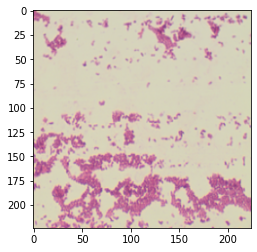

In [18]:
# Path to image you want to classify
image_to_check = 'Dataset/DIBaS/Listeria.monocytogenes/Listeria.monocytogenes_0013.tif'

def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.permute((1, 2, 0))
    ## Inference#### Defining and visualizing an image to classify. 
    image = image.numpy()
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    if title is not None:
        ax.set_title(title)
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

class_to_check = image_to_check.split("/")[2]
print("Target class:", class_to_check)

image = prepare_image(image_to_check)
imshow(image)

#### Top 5 most probable classes over the test image.


Predictions: [500.60406494140625, 6.252551555633545, 0.23258037865161896, 0.013482668437063694, 0.010835534892976284]
['Listeria.monocytogenes', 'Acinetobacter.baumanii', 'Neisseria.gonorrhoeae', 'Pseudomonas.aeruginosa', 'Lactobacillus.casei']


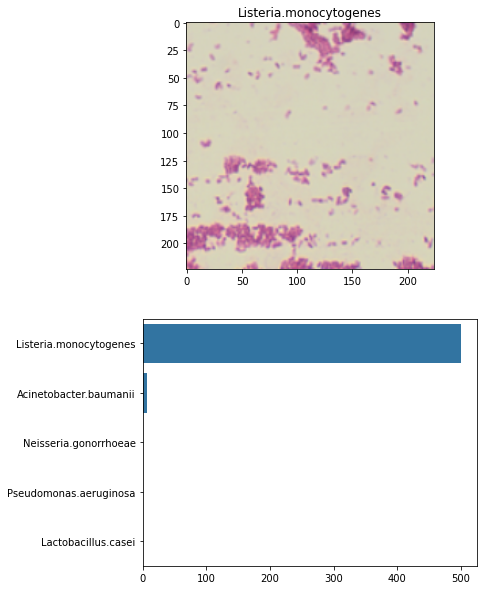

In [19]:
#### Top 5 most probable classes over the test image.# Display an image along with the top 5 classes
# Predictions
load_probs, load_classes = predict(image_to_check, load_model)
print("\nPredictions:", load_probs)
print(load_classes)

# Plot flower input image
plt.figure(figsize = (6,10))
plot_1 = plt.subplot(2,1,1)

image = prepare_image(image_to_check)

flower_title = class_to_check

imshow(image, plot_1, title=flower_title);

# Top 5 predicted species name
pred_species = load_classes[:5]

# Plot the probabilities for the top 5 classes as a bar graph
plt.subplot(2,1,2)

sb.barplot(x=load_probs, y=pred_species, color=sb.color_palette()[0]);

plt.show()